In [211]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sys
import calendar
import pickle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [229]:
df1=pd.read_csv(r'~\avalanche_sat\Data\dataset1.csv')
df1['Dataset']='Data1'
df2=pd.read_csv(r'~\avalanche_sat\Data\dataset2.csv')
df2['Dataset']='Data2'
df3=pd.read_csv(r'~\avalanche_sat\Data\dataset3_nowcast.csv')
df3['Dataset']='Data3_nowcast'

df=pd.concat([df1, df2,df3]).drop(columns='Unnamed: 0')
df = df.loc[:, ~df.columns.duplicated()]


df['year']=pd.to_datetime(df['datum']).dt.year
df['month'] = pd.to_datetime(df['datum']).dt.strftime('%B')



month_order = list(calendar.month_name)[1:]  # ['January', ..., 'December']

selected_months = [ 'December','January', 'February', 'March', 'April']

In [225]:
df=df.drop(columns=['Unnamed: 0.1.1'])

In [232]:
df.to_csv(r'~\avalanche_sat\Data\full_dataset.csv', index=False)

In [218]:
df

,datum,station_code,aspect,elevation,avalancheDay1,max_height,TSS_mod,prop_base_3_diff,ILWR_daily,RH_daily,...,MS_Rain_daily,MS_Rain,profile_time,Dataset,lon,lat,Unnamed: 0.1.1,RF12_AvD_proba,year,month
0,2020-01-13,ALB2,2.0,2322.0,0,103.39,-9.163,0.0,195.538500,25.10000,...,0.0,0.0,15:00:00,Data1,NaN,NaN,NaN,NaN,2020,January
1,2020-01-23,ALB2,2.0,2322.0,0,100.71,-10.366,0.0,178.027875,25.00000,...,0.0,0.0,15:00:00,Data1,NaN,NaN,NaN,NaN,2020,January
2,2020-01-10,ALB2,2.0,2322.0,0,104.78,-13.180,0.0,206.648875,58.98750,...,0.0,0.0,15:00:00,Data1,NaN,NaN,NaN,NaN,2020,January
3,2020-01-07,ALB2,2.0,2322.0,0,106.02,-10.190,0.0,203.045875,56.32500,...,0.0,0.0,15:00:00,Data1,NaN,NaN,NaN,NaN,2020,January
4,2020-02-12,ALB2,2.0,2322.0,0,120.11,-10.941,0.0,195.496250,74.22500,...,0.0,0.0,15:00:00,Data1,NaN,NaN,NaN,NaN,2020,February
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,2022-04-21,ILI2,1.0,2022.0,0,202.96,0.000,0.0,261.564000,79.78750,...,0.0,0.0,15:00:00,Data3_nowcast,6.827797,46.191356,NaN,0.412307,2022,April
2244,2021-12-21,ILI2,1.0,2022.0,0,152.91,-8.830,0.0,188.422250,20.61250,...,0.0,0.0,15:00:00,Data3_nowcast,6.827797,46.191356,2021-12-21,0.000000,2021,December
2245,2022-01-28,ILI2,1.0,2022.0,0,156.12,-12.734,0.0,216.666250,33.52500,...,0.0,0.0,15:00:00,Data3_nowcast,6.827797,46.191356,2022-01-28,0.001977,2022,January
2246,2022-02-14,ILI2,1.0,2022.0,0,190.24,-3.673,0.0,258.314000,72.63750,...,0.0,0.0,15:00:00,Data3_nowcast,6.827797,46.191356,NaN,0.055750,2022,February


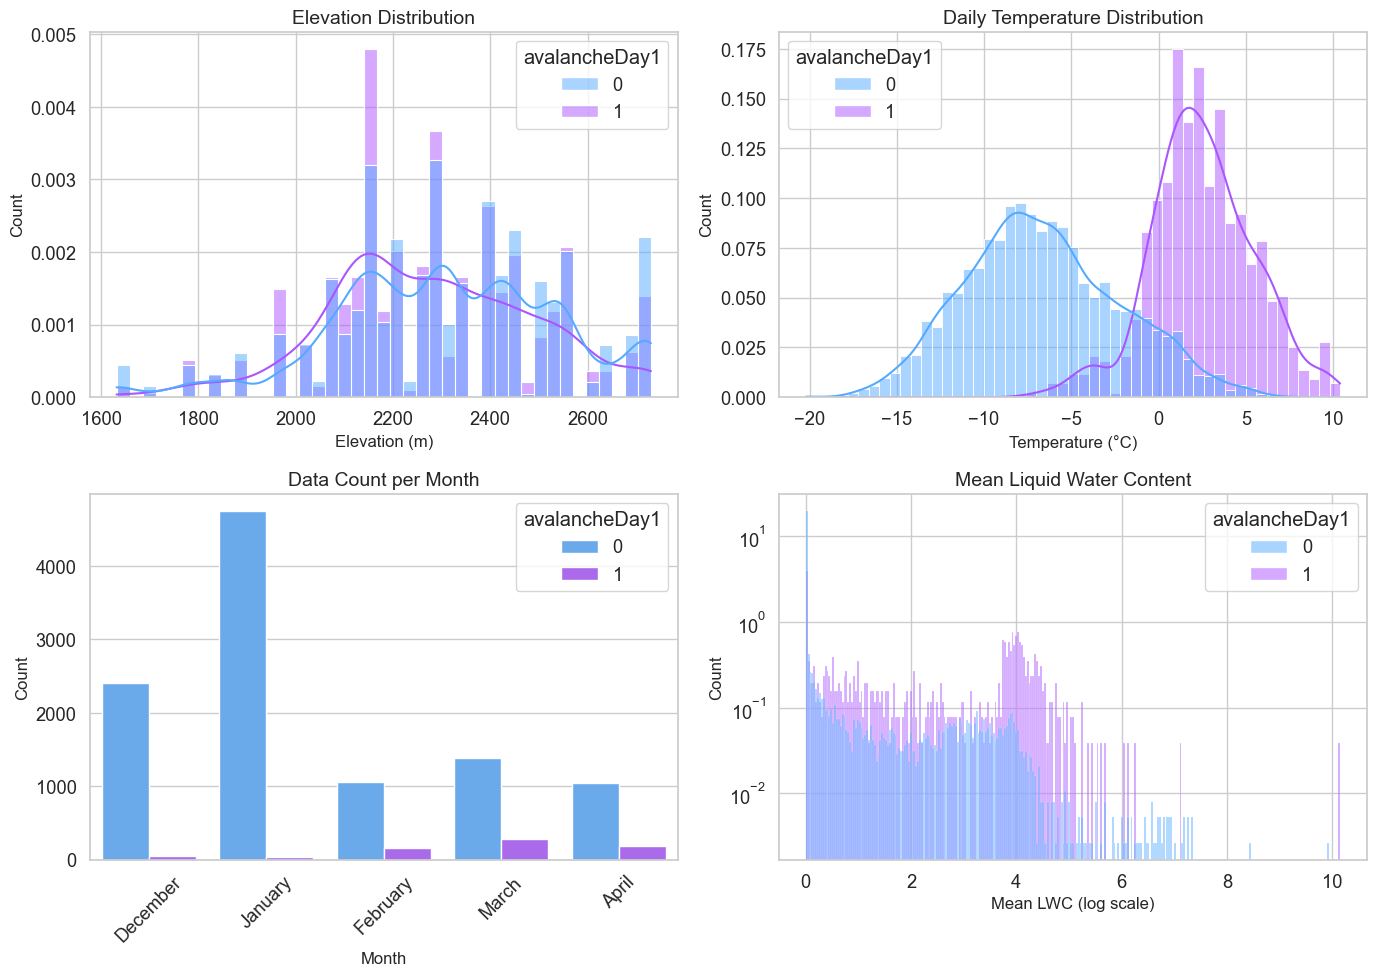

In [214]:

# Set a pretty seaborn style
sns.set(style='whitegrid', font_scale=1.2)

# Prepare month order
selected_months = ['December', 'January', 'February', 'March', 'April']

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
ax = ax.flat

# 1st plot: Elevation Histogram
sns.histplot(
    data=df,
    x='elevation',
    ax=ax[0],
    kde=True,
 palette='cool',

    hue='avalancheDay1',
    stat='density',   # <-- THIS normalizes it!
    common_norm=False # <-- THIS normalizes *separately* for each hue
)
ax[0].set_title('Elevation Distribution', fontsize=14)
ax[0].set_xlabel('Elevation (m)', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)

# 2nd plot: Temperature Histogram
sns.histplot(data=df, x='TA_daily', ax=ax[1], kde=True, hue='avalancheDay1',  stat='density',  common_norm=False, palette='cool')
ax[1].set_title('Daily Temperature Distribution', fontsize=14)
ax[1].set_xlabel('Temperature (°C)', fontsize=12)
ax[1].set_ylabel('Count', fontsize=12)

# 3rd plot: Month Countplot
sns.countplot(data=df, x='month', ax=ax[2], order=selected_months, palette='cool', hue='avalancheDay1')
ax[2].set_title('Data Count per Month', fontsize=14)
ax[2].set_xlabel('Month', fontsize=12)
ax[2].set_ylabel('Count', fontsize=12)
ax[2].tick_params(axis='x', rotation=45)

# 4th plot: Mean LWC Histogram
sns.histplot(
    data=df,
    x='mean_lwc',
    ax=ax[3],
 palette='cool',
    hue='avalancheDay1',
    stat='density',
    common_norm=False
)
ax[3].set_title('Mean Liquid Water Content', fontsize=14)
ax[3].set_xlabel('Mean LWC (log scale)', fontsize=12)
ax[3].set_ylabel('Count', fontsize=12)
ax[3].set_yscale('log')

# Adjust layout
plt.tight_layout()
plt.show()



In [204]:
# Drop non-numeric columns and missing data
df_numeric = df.select_dtypes(include=["number"]).dropna(axis=1).drop(columns=['year'])

# Split features and target
X = df_numeric.drop(columns=["avalancheDay1"])
y = df_numeric["avalancheDay1"]

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [205]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
# Score
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)
y_pred=model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1


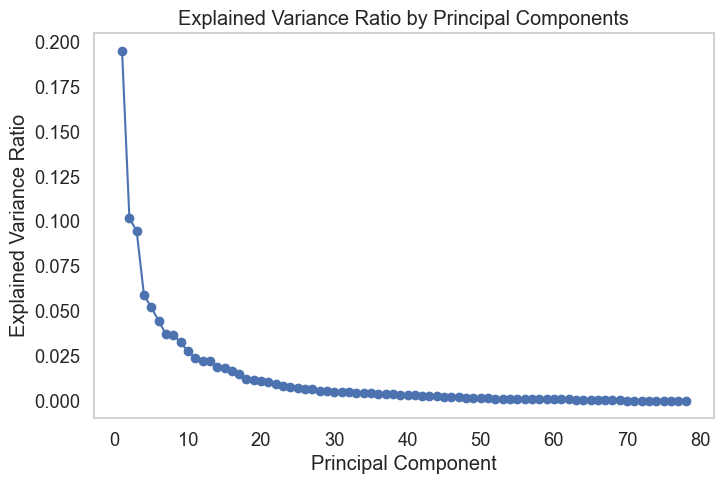

In [206]:

# Apply PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Analyze variance
explained_variance_ratio = pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Explained Variance Ratio by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()


               Train Accuracy  Test Accuracy  Precision    Recall  F1 Score
1_components         0.941709       0.947888   0.655738  0.350877  0.457143
2_components         0.944864       0.953922   0.727273  0.421053  0.533333
3_components         0.943766       0.954471   0.731343  0.429825  0.541436
27_components        0.981621       0.986286   0.908257  0.868421  0.887892


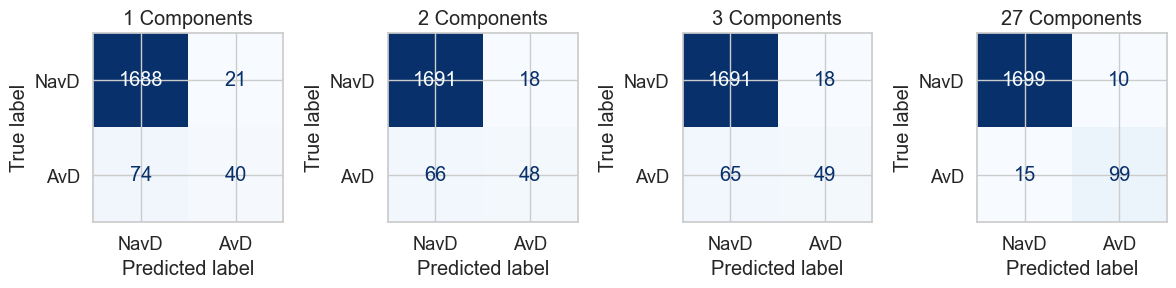

In [207]:
# Initialize dictionary to store results
results = {}

# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 3))

# Loop through different numbers of PCA components
for i, n_components in enumerate([1, 2, 3, min(27, X_train_scaled.shape[1])]):
    pipe = Pipeline([
        ('pca', PCA(n_components=n_components)),
        ('logreg', LogisticRegression())
    ])
    pipe.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = pipe.predict(X_test_scaled)
    
    # Scores
    train_score = pipe.score(X_train_scaled, y_train)
    test_score = pipe.score(X_test_scaled, y_test)
    
    # Save metrics
    results[f'{n_components}_components'] = {
        'Train Accuracy': train_score,
        'Test Accuracy': test_score, 
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred)
    }
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NavD", "AvD"])
    disp.plot(cmap='Blues', values_format='d', ax=ax[i], colorbar=False)
    ax[i].set_title(f'{n_components} Components')

# Adjust layout
plt.tight_layout()

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


In [208]:
np.cumsum(explained_variance_ratio)[[0, 1, 2, 27]]

array([0.19510405, 0.29712186, 0.39154266, 0.91406437])

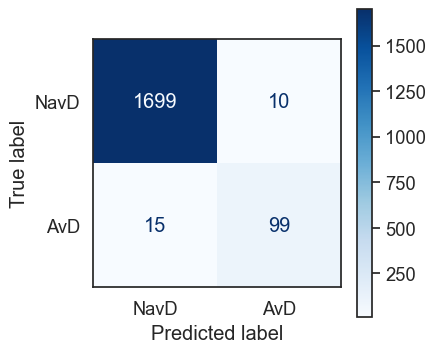

In [209]:
sns.set(style='white', font_scale=1.2)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize by row (optional, like your image)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NavD", "AvD"])
disp.plot(cmap='Blues', values_format='d', ax=ax)
plt.show()


In [189]:
df['avalancheDay1'].value_counts()

avalancheDay1
0    10638
1      724
Name: count, dtype: int64

In [210]:

print("Accuracy:", np.round(accuracy_score(y_test, y_pred), 2))
print("Precision:", np.round(precision_score(y_test, y_pred), 2))
print("Recall:", np.round(recall_score(y_test, y_pred), 2))
print("F1 Score:", np.round(f1_score(y_test, y_pred), 2))


Accuracy: 0.99
Precision: 0.91
Recall: 0.87
F1 Score: 0.89


In [164]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_scaled, i) for i in range(X_train_scaled.shape[1])]
print(vif_data)


c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


             Feature         VIF
0             aspect    1.677518
1          elevation    1.424166
2         max_height   20.562290
3            TSS_mod  730.568298
4   prop_base_3_diff   28.572987
..               ...         ...
73      HS_mod_daily   57.003262
74      water_1_diff    8.462820
75   sum_base_2_diff   14.748864
76     MS_Rain_daily    3.995572
77           MS_Rain    3.255389

[78 rows x 2 columns]


In [168]:
vif_data[vif_data['VIF']>10]

,Feature,VIF
2,max_height,2.056229e+01
3,TSS_mod,7.305683e+02
4,prop_base_3_diff,2.857299e+01
6,RH_daily,1.558946e+01
7,ISWR_diff_daily,1.028840e+01
8,prop_base_1_diff,2.426869e+01
9,prop_wet_2_diff,4.357857e+01
10,prop_wet_3_diff,3.452557e+01
12,lowest_2_diff,1.049135e+01
13,mean_lwc_3_diff,1.462289e+01


In [ ]:
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", scores.mean())

Cross-Validation Accuracy Scores: [0.98569857 0.98514851 0.99064906 0.98679868 0.98899285]
Mean CV Accuracy: 0.9874575349664851
